# Homework 12 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (b05902127@ntu.edu.tw)

## **goal**

----- strong baseline -----
0.69738     
----- simple baseline -----
0.51018 

助教的 code: 0.49832

# Readme


HW12的任務是Transfer Learning中的Domain Adversarial Training。

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 也就是左下角的那一塊。

## Scenario and Why Domain Adversarial Training
你現在有Source Data + label，其中Source Data和Target Data可能有點關係，所以你想要訓練一個model做在Source Data上並Predict在Target Data上。

但這樣有什麼樣的問題? 相信大家學過Anomaly Detection就會知道，如果有data是在Source Data沒有出現過的(或稱Abnormal的)，那麼model大部分都會因為不熟悉這個data而可能亂做一發。 

以下我們將model拆成Feature Extractor(上半部)和Classifier(下半部)來作例子:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

整個Model在學習Source Data的時候，Feature Extrator因為看過很多次Source Data，所以所抽取出來的Feature可能就頗具意義，例如像圖上的藍色Distribution，已經將圖片分成各個Cluster，所以這個時候Classifier就可以依照這個Cluster去預測結果。

但是在做Target Data的時候，Feature Extractor會沒看過這樣的Data，導致輸出的Target Feature可能不屬於在Source Feature Distribution上，這樣的Feature給Classifier預測結果顯然就不會做得好。

## Domain Adversarial Training of Nerural Networks (DaNN)
基於如此，是不是只要讓Soucre Data和Target Data經過Feature Extractor都在同個Distribution上，就會做得好了呢? 這就是DaNN的主要核心。

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

我們追加一個Domain Classifier，在學習的過程中，讓Domain Classifier去判斷經過Feature Extractor後的Feature是源自於哪個domain，讓Feature Extractor學習如何產生Feature以**騙過**Domain Classifier。 持久下來，通常Feature Extractor都會打贏Domain Classifier。(因為Domain Classifier的Input來自於Feature Extractor，而且對Feature Extractor來說Domain&Classification的任務並沒有衝突。)

如此一來，我們就可以確信不管是哪一個Domain，Feature Extractor都會把它產生在同一個Feature Distribution上。

# Data Introduce

這次的任務是Source Data: 真實照片，Target Data: 手畫塗鴉。

我們必須讓model看過真實照片以及標籤，嘗試去預測手畫塗鴉的標籤為何。

資料位於[這裡](https://drive.google.com/open?id=16p0eoReFvKUq9meLKB7hGEVoDVl_7IaP)，以下的code分別為下載和觀看這次的資料大概長甚麼樣子。

特別注意一點: **這次的source和target data的圖片都是平衡的，你們可以使用這個資訊做其他事情。**

In [ ]:
folder_path = './'

In [ ]:
# mine
# Download dataset
!gdown --id '1gmquY08U422x_V5aTt749cMkJUh45szv' --output real_or_drawing.zip

# Unzip the files
!unzip real_or_drawing.zip

In [ ]:
import random
import torch
import numpy as np

# 固定隨機種子
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

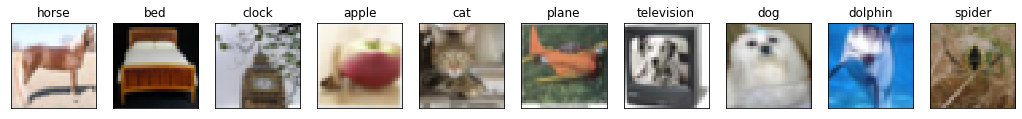

In [ ]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, 縮放模式為nearest。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # 不要顯示axis。
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i]) #taining_data => real

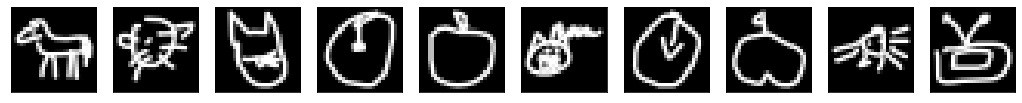

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp')) #testing_data => comic

# Special Domain Knowledge

因為大家塗鴉的時候通常只會畫輪廓，我們可以根據這點將source data做點邊緣偵測處理，讓source data更像target data一點。

## Canny Edge Detection
算法這邊不贅述，只教大家怎麼用。若有興趣歡迎參考wiki或[這裡](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19)。

cv2.Canny使用非常方便，只需要兩個參數: low_threshold, high_threshold。

```cv2.Canny(image, low_threshold, high_threshold)```

簡單來說就是當邊緣值超過high_threshold，我們就確定它是edge。如果只有超過low_threshold，那就先判斷一下再決定是不是edge。

以下我們直接拿source data做做看。

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


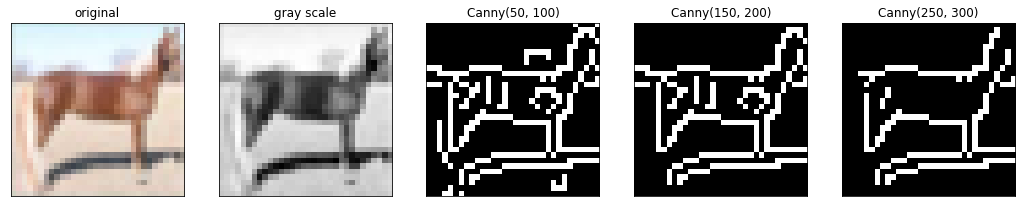

In [ ]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

# change threshold
canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process

在這裡我故意將data用成可以使用torchvision.ImageFolder的形式，所以只要使用該函式便可以做出一個datasets。

transform的部分請參考以下註解。

#### 一些細節

在一般的版本上，對灰階圖片使用RandomRotation使用```transforms.RandomRotation(15)```即可。但在colab上需要加上```fill=(0,)```才可運行。
在n98上執行需要把```fill=(0,)```拿掉才可運行。


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# training_data
source_transform = transforms.Compose([
    # 轉灰階: Canny 不吃 RGB。
    transforms.Grayscale(),

    # cv2 不吃 skimage.Image，因此轉成np.array後再做cv2.Canny
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),

    # 重新將np.array 轉回 skimage.Image
    transforms.ToPILImage(),

    # 水平翻轉 (Augmentation)
    transforms.RandomHorizontalFlip(),

    # 旋轉15度內 (Augmentation)，旋轉後空的地方補0
    transforms.RandomRotation(15, fill=(0,)),

    # 最後轉成Tensor供model使用。
    transforms.ToTensor(),
])


target_transform = transforms.Compose([
    # 轉灰階: 將輸入3維壓成1維。
    transforms.Grayscale(),

    # 縮放: 因為source data是32x32，我們將target data的28x28放大成32x32。
    transforms.Resize((32, 32)),

    # 水平翻轉 (Augmentation)
    transforms.RandomHorizontalFlip(),

    # 旋轉15度內 (Augmentation)，旋轉後空的地方補0
    transforms.RandomRotation(15, fill=(0,)),

    # 最後轉成Tensor供model使用。
    transforms.ToTensor(),
])

source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)

# TA 原本助教使用的超參數
# source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
# target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)

# Mine
source_dataloader = DataLoader(source_dataset, batch_size = 64, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size = 64, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model

Feature Extractor: 典型的VGG-like疊法。

Label Predictor / Domain Classifier: MLP到尾。

相信作業寫到這邊大家對以下的Layer都很熟悉，因此不再贅述。

TA 助教使用的模型架構，可以當參考使用

In [ ]:
# class FeatureExtractor(nn.Module):

#     def __init__(self):
#         super(FeatureExtractor, self).__init__()

#         self.conv = nn.Sequential(
#             nn.Conv2d(1, 64, 3, 1, 1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(64, 128, 3, 1, 1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(128, 256, 3, 1, 1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(256, 256, 3, 1, 1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(256, 512, 3, 1, 1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
        
#     def forward(self, x):
#         x = self.conv(x).squeeze()
#         return x

# class LabelPredictor(nn.Module):

#     def __init__(self):
#         super(LabelPredictor, self).__init__()

#         self.layer = nn.Sequential(
#             nn.Linear(512, 512),
#             nn.ReLU(),

#             nn.Linear(512, 512),
#             nn.ReLU(),

#             nn.Linear(512, 10),
#         )

#     def forward(self, h):
#         c = self.layer(h)
#         return c

# class DomainClassifier(nn.Module):

#     def __init__(self):
#         super(DomainClassifier, self).__init__()

#         self.layer = nn.Sequential(
#             nn.Linear(512, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),

#             nn.Linear(512, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),

#             nn.Linear(512, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),

#             nn.Linear(512, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),

#             nn.Linear(512, 1),
#         )

#     def forward(self, h):
#         y = self.layer(h)
#         return y

Mine 我改善的模型架構

In [ ]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 5, 1, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.LeakyReLU(negative_slope=0.01, inplace=False),
            # nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # nn.LeakyReLU(negative_slope=0.01, inplace=False),
            # nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8] ps.padding 後從 8 => 10，再從 10-3+1 = 8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.MaxPool2d(2, 2, 0),       # 

            nn.Conv2d(512, 512, 3, 1, 1), # 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.MaxPool2d(2, 2, 0) 
        )          
    
    # 先看torch.squeeze() 這個函數主要對數據的維度進行壓縮，去掉維數為1的的維度，比如是一行或者一列這種，
    # 一個一行三列（1,3）的數去掉第一個維數為一的維度之後就變成（3）行。 squeeze(a)就是將a中所有為1的維度刪掉。
    # 不為1的維度沒有影響。 a.squeeze(N) 就是去掉a中指定的維數為一的維度。還有一種形式就是b=torch.squeeze(a，N) a中去掉指定的定的維數為一的維度。

    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Pre-processing

這裡我們選用Adam來當Optimizer。

nn.BCEWithLogitsLoss() 介紹：     
https://blog.csdn.net/qq_22210253/article/details/85222093

In [ ]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

# set loss function
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

# set optimizer
optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

查看參數資料

In [ ]:
from torchsummary import summary
summary(feature_extractor, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,664
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]         295,168
       BatchNorm2d-8          [-1, 256, 32, 32]             512
              ReLU-9          [-1, 256, 32, 32]               0
        MaxPool2d-10          [-1, 256, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         590,080
      BatchNorm2d-12          [-1, 256, 16, 16]             512
             ReLU-13          [-1, 256, 16, 16]               0
        MaxPool2d-14            [-1, 25

In [ ]:
from torchsummary import summary
summary(label_predictor, input_size=(2*2, 512))

In [ ]:
from torchsummary import summary
summary(domain_classifier, input_size=(512, 512))

# Start Training


## 如何實作DaNN?

理論上，在原始paper中是加上Gradient Reversal Layer，並將Feature Extractor / Label Predictor / Domain Classifier 一起train，但其實我們也可以交換的train Domain Classfier & Feature Extractor(就像在train GAN的Generator & Discriminator一樣)，這也是可行的。

在code實現中，我們採取後者的方式，畢竟大家上個作業就是GAN，應該會比較熟悉:)。

## 小提醒
* 原文中的lambda(控制Domain Adversarial Loss的係數)是有Adaptive的版本，如果有興趣可以參考[原文](https://arxiv.org/pdf/1505.07818.pdf)。以下為了方便固定設置0.1。
* 因為我們完全沒有target的label，所以結果如何，只好丟kaggle看看囉:)?

可以增加 acc 的文獻做法：     
https://arxiv.org/pdf/1412.3474.pdf

BatchNorm、Relu、Dropout 等的相對順序和 BN、Dropout的問題思考：    
https://blog.csdn.net/m0_37870649/article/details/82025238?utm_medium=distribute.pc_relevant.none-task-blog-baidujs-3         
BatchNorm 可能的問題：      
https://blog.csdn.net/LoseInVain/article/details/86476010

In [ ]:
import time

def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: 調控adversarial的loss係數。
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    # total_hit: 計算目前對了幾筆 total_num: 目前經過了幾筆
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # 我們把source data和target data混在一起，否則batch_norm可能會算錯 (兩邊的data的mean/var不太一樣)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # 設定source data的label為1
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : 訓練Domain Classifier
        feature = feature_extractor(mixed_data)
        # 因為我們在Step 1不需要訓練Feature Extractor，所以把feature detach避免loss backprop上去。
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : 訓練Feature Extractor和Domain Classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss為原本的class CE - lamb * domain BCE，相減的原因同GAN中的Discriminator中的G loss。
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

best_acc = 0

# TA 訓練200 epochs
for epoch in range(300):
    training_start_time = time.time()
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=0.1)

    if(train_acc > best_acc):
        torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
        torch.save(label_predictor.state_dict(), f'predictor_model.bin')
        best_acc = train_acc
        print('save model')

    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))
    print('training cost time =', time.time() - training_start_time, '(sec)', 'best acc =', best_acc)

In [ ]:
torch.save(feature_extractor.state_dict(), folder_path + f'extractor_model_7.bin')
torch.save(label_predictor.state_dict(), folder_path + f'predictor_model_7.bin')

# Inference

就跟前幾次作業一樣。這裡我使用pd來生產csv，因為看起來比較潮(?)

此外，200 epochs的Accuracy可能會不太穩定，可以多丟幾次或train久一點。

In [ ]:
import time

label_predictor = LabelPredictor().cuda()
feature_extractor = FeatureExtractor().cuda()
label_predictor.load_state_dict(torch.load(folder_path + f'predictor_model_7.bin', map_location='cuda'))
feature_extractor.load_state_dict(torch.load(folder_path + f'extractor_model_7.bin', map_location='cuda'))

result = []
label_predictor.eval()
feature_extractor.eval()
testing_start_time = time.time()
for i, (test_data, _) in enumerate(test_dataloader):
    test_data = test_data.cuda()

    class_logits = label_predictor(feature_extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)
print('testing cost time =', time.time() - testing_start_time, '(sec)')

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)
# print(df)

testing cost time = 118.63016295433044 (sec)


In [ ]:
from google.colab import files
files.download('DaNN_submission.csv') 

## semi-supervised
可以更加地使準確率上升

### testing for target_data 

In [ ]:
import time

label_predictor = LabelPredictor().cuda()
feature_extractor = FeatureExtractor().cuda()
label_predictor.load_state_dict(torch.load(folder_path + f'predictor_model_7.bin', map_location='cuda'))
feature_extractor.load_state_dict(torch.load(folder_path + f'extractor_model_7.bin', map_location='cuda'))

labeled_target_data = []
labeled_target_label = []
threshold = 0.999

label_predictor.eval()
feature_extractor.eval()
soft_testing_start_time = time.time()

with torch.no_grad(): #不佔用 GPU
# target_data batch_size = 64
    for i, (target_data, _) in enumerate(target_dataloader):
        target_data = target_data.cuda()

        class_logits = label_predictor(feature_extractor(target_data))
        temp = nn.Softmax(dim=1)
        class_logits = temp(class_logits)

        x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
        max_values, max_indices = torch.max(class_logits, dim = 1)[0].cpu().detach().numpy(), torch.max(class_logits,dim = 1)[1].cpu().detach().numpy()

        labeled_target_data.extend(target_data[max_values > threshold, :, :, :])
        labeled_target_label.extend(max_indices[max_values > threshold])

        if(i%300 == 0):
            print('target_data_{}'.format(i) + '_done')

print('soft_testing cost time =', time.time() - soft_testing_start_time, '(sec)')
print(len(labeled_target_data))

target_data_0_done
target_data_300_done
target_data_600_done
target_data_900_done
target_data_1200_done
target_data_1500_done
soft_testing cost time = 56.72210669517517 (sec)
52314


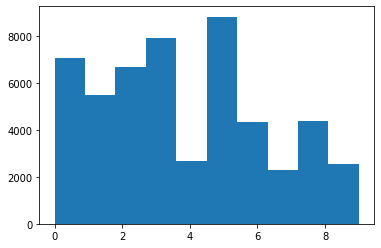

num of labeled_target_label = 52314


In [ ]:
plt.hist(labeled_target_label)
plt.show()
print('num of labeled_target_label =', len(labeled_target_label))

### get the confident target_data as new training_data

In [ ]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                  
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight 

In [ ]:
soft_label_dataset = [(data.cpu(), label) for data, label in zip(labeled_target_data, labeled_target_label)]
semi_dataset = []
semi_dataset.extend(soft_label_dataset)
semi_dataloader = DataLoader(semi_dataset, batch_size = 256, shuffle=True)

In [ ]:
workers = 5
weights = make_weights_for_balanced_classes(soft_label_dataset, 10)                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                                    
train_loader = torch.utils.data.DataLoader(semi_dataset, batch_size=256, sampler = sampler, num_workers=workers, pin_memory=True)

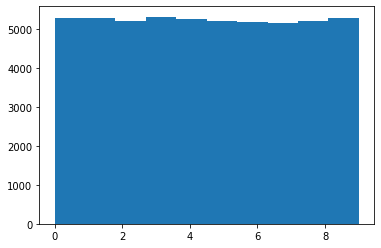

In [ ]:
balanced_label = []
for i, data in enumerate(train_loader):
  balanced_label.extend(data[1].numpy())
plt.hist(balanced_label); 
plt.show()

### set classifer model

In [ ]:
# # best_model
# 我本來自己疊的架構，但發現沒有比較好，可以使用下面那個來訓練

# class Classifier(nn.Module):
#     def __init__(self):
#         super(Classifier, self).__init__()
#         self.cnn = nn.Sequential(

#             nn.Conv2d(1, 64, 3, 1, 1), 
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             # nn.MaxPool2d(2, 2, 0),      

#             nn.Conv2d(64, 128, 3, 1, 1), 
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),     

#             nn.Conv2d(128, 256, 3, 1, 1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),       

#             nn.Conv2d(256, 512, 3, 1, 1), 
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),      
            
#             nn.Conv2d(512, 512, 3, 1, 1), 
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),  

#             nn.Conv2d(512, 512, 3, 1, 1), 
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),      
#         )
#         self.fc = nn.Sequential(
#             # flatten
#             nn.Linear(512*1*1, 256),
#             nn.ReLU(),
#             nn.Dropout2d(0.5),

#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Dropout2d(0.5),
            
#             nn.Linear(128, 10)
#         )

#     def forward(self, x):
#         out = self.cnn(x)
#         out = out.view(out.size()[0], -1)
#         return self.fc(out)

In [ ]:
# str
# 可以過 strong baseline 的 model

drop_rate = 0.5
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128] 
        # [1,256,256]
        self.cnn = nn.Sequential( 
            nn.Conv2d(1, 64, 3, 1, 1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),     

            nn.Conv2d(128, 256, 3, 1, 1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),     
            nn.Conv2d(256, 512, 3, 1, 1), 
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2, 0), 
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2, 0), 
            nn.ReLU(),
          
        )
        self.fc = nn.Sequential( 
            nn.Linear(128*2*2, 256),  
            nn.ReLU(),
            nn.Dropout2d(drop_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout2d(drop_rate),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [ ]:
model = Classifier().cuda()
from torchsummary import summary
summary(model, input_size=(1, 32, 32))

### training

In [ ]:
model = Classifier().cuda()

loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.02)
num_epoch = 3
best_acc = 0
batch_size = 256

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        # if (epoch < -1):
        #     optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
        # else:
        #     optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.2) # optimizer 使用 SGD
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

        #將結果 print 出來
    if(train_acc > best_acc):
        best_acc = train_acc
        print('save model')
        torch.save(model.state_dict(), 'final_semi_model.bin')

    print('epoch =', epoch + 1, ' cost_time =', time.time() - epoch_start_time)
    print('acc =', train_acc/len(balanced_label), ' loss =', train_loss/len(balanced_label), ' best_acc =', best_acc/len(balanced_label))
        
print('best_acc =', best_acc/len(balanced_label))
# 注意這裡不用訓練太多次，以免 overfitting

save model
epoch = 1  cost_time = 7.069637298583984
acc = 0.5141835837443132  loss = 0.005995080806421761  best_acc = 0.5141835837443132
save model
epoch = 2  cost_time = 7.048750162124634
acc = 0.8055587414458845  loss = 0.0025886028250792243  best_acc = 0.8055587414458845
save model
epoch = 3  cost_time = 7.0642006397247314
acc = 0.873437320793669  loss = 0.0016944263768897043  best_acc = 0.873437320793669
best_acc = 0.873437320793669


In [ ]:
# save model
model_name = 'str.bin'
torch.save(model.state_dict(), folder_path + model_name) #先 train 一輪少 epoch

### testing

In [ ]:
import time

model_name = 'str.bin'
model = Classifier().cuda()
model.load_state_dict(torch.load(folder_path + model_name, map_location='cuda'))

model.eval()
result = []
testing_start_time = time.time()
with torch.no_grad():
    for i, (test_data, _) in enumerate(test_dataloader):
        test_pred = model(test_data.cuda())
        # test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        # for y in test_label:
        #     prediction.append(y)

        x = torch.argmax(test_pred, dim=1).cpu().detach().numpy()
        result.append(x)

import pandas as pd
result = np.concatenate(result)
print('testing cost time =', time.time() - testing_start_time, '(sec)')

# Generate your submission
prediction_name = 'str.csv'
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv(prediction_name, index=False)
# print(df)

testing cost time = 50.53427219390869 (sec)


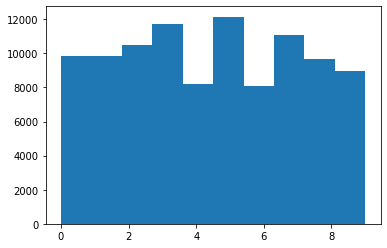

In [ ]:
plt.hist(result)
plt.show()

In [ ]:
from google.colab import files
files.download(prediction_name) 

## 二次 semi
因為當時怎麼樣都無法有更好的準確率，因此我再做一次 semi-suprevised，讀者可以當參考就好

In [ ]:
import time
labeled_target_data_1 = []
labeled_target_label_1 = []


model = Classifier().cuda()
# model.load_state_dict(torch.load(folder_path + model_name, map_location='cuda'))
model.load_state_dict(torch.load('final_semi_model.bin', map_location='cuda')) # 讀者可能要注意且改一下檔名才可以跑喔

model.eval()
threshold = 0.8
testing_start_time = time.time()
with torch.no_grad():
    for i, (target_data, _) in enumerate(target_dataloader):
        class_logits = model(target_data.cuda())
        temp = nn.Softmax(dim=1)
        class_logits = temp(class_logits)
        max_values, max_indices = torch.max(class_logits, dim = 1)[0].cpu().detach().numpy(), torch.max(class_logits,dim = 1)[1].cpu().detach().numpy()

        labeled_target_data_1.extend(target_data[max_values > threshold, :, :, :])
        labeled_target_label_1.extend(max_indices[max_values > threshold])

        if(i%300 == 0):
            print('target_data_{}'.format(i) + '_done')

print('soft_testing cost time =', time.time() - soft_testing_start_time, '(sec)')
print(len(labeled_target_data_1))

target_data_0_done
target_data_300_done
target_data_600_done
target_data_900_done
target_data_1200_done
target_data_1500_done
soft_testing cost time = 1778.7707171440125 (sec)
41306


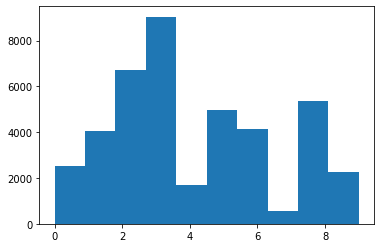

num of labeled_target_label = 41306


In [ ]:
plt.hist(labeled_target_label_1)
plt.show()
print('num of labeled_target_label =', len(labeled_target_label_1))

In [ ]:
soft_label_dataset = [(data.cpu(), label) for data, label in zip(labeled_target_data_1, labeled_target_label_1)]
semi_dataset = []
semi_dataset.extend(soft_label_dataset)
semi_dataloader = DataLoader(semi_dataset, batch_size = 256, shuffle=True)

In [ ]:
workers = 5
weights = make_weights_for_balanced_classes(soft_label_dataset, 10)                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                                    
train_loader = torch.utils.data.DataLoader(semi_dataset, batch_size=256, sampler = sampler, num_workers=workers, pin_memory=True)

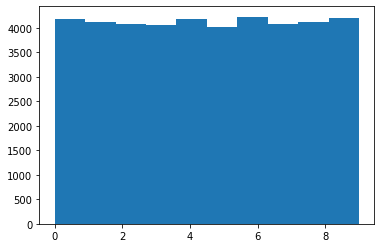

In [ ]:
balanced_label = []
for i, data in enumerate(train_loader):
  balanced_label.extend(data[1].numpy())
plt.hist(balanced_label); 
plt.show()

In [ ]:
model = Classifier().cuda()

loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.02)
num_epoch = 1
best_acc = 0
batch_size = 256

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        # if (epoch < -1):
        #     optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
        # else:
        #     optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.2) # optimizer 使用 SGD
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

        #將結果 print 出來
    if(train_acc > best_acc):
        best_acc = train_acc
        print('save model')
        torch.save(model.state_dict(), 'final_semi_model.bin')

    print('epoch =', epoch + 1, ' cost_time =', time.time() - epoch_start_time)
    print('acc =', train_acc/len(balanced_label), ' loss =', train_loss/len(balanced_label), ' best_acc =', best_acc/len(balanced_label))
        
print('best_acc =', best_acc/len(balanced_label))

save model
epoch = 1  cost_time = 18.3885235786438
acc = 0.6695153246501719  loss = 0.004607642592457035  best_acc = 0.6695153246501719
best_acc = 0.6695153246501719


In [ ]:
import time

model = Classifier().cuda()
# model.load_state_dict(torch.load(folder_path + model_name, map_location='cuda'))
model.load_state_dict(torch.load('final_semi_model.bin', map_location='cuda'))

model.eval()
result = []
testing_start_time = time.time()
with torch.no_grad():
    for i, (test_data, _) in enumerate(test_dataloader):
        test_pred = model(test_data.cuda())
        # test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        # for y in test_label:
        #     prediction.append(y)

        x = torch.argmax(test_pred, dim=1).cpu().detach().numpy()
        result.append(x)

import pandas as pd
result = np.concatenate(result)
print('testing cost time =', time.time() - testing_start_time, '(sec)')

# Generate your submission
prediction_name = 'qq.csv'
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv(prediction_name, index=False)
# print(df)

testing cost time = 48.87177515029907 (sec)


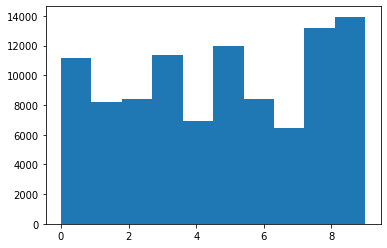

In [ ]:
plt.hist(result)
plt.show()

## 使用 PCA 降維 (報告第二、第三題)

PCA: 首先計算 training data 的 principle component，將 testing data 投影在這些 component 上，再將這些投影重建回原先 space 的向量。對重建的圖片和原圖計算 MSE，inlier data 的數值應該較 outlier 的數值為小。

In [ ]:
source_data_list = []
target_data_list = []
source_data_DANN_list = []
target_data_DANN_list = []

# before DANN
for i, ((source_data, _), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):
    source_data_list.extend(source_data.cuda())
    target_data_list.extend(target_data.cuda())
print('finish before DANN')

# after DANN
# label_predictor = LabelPredictor().cuda()
feature_extractor = FeatureExtractor().cuda()
# label_predictor.load_state_dict(torch.load(folder_path + f'predictor_model_1.bin', map_location='cuda'))
feature_extractor.load_state_dict(torch.load(folder_path + f'extractor_model_6.bin', map_location='cuda'))

# label_predictor.eval()
feature_extractor.eval()
with torch.no_grad():
    for i, ((source_data, _), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_class_logits = feature_extractor(source_data.cuda())
        target_class_logits = feature_extractor(target_data.cuda())
        # source_class_logits = source_class_logits.reshape(-1, 512, 1, 1)
        # target_class_logits = target_class_logits.reshape(-1, 512, 1, 1)
        source_data_DANN_list.extend(source_class_logits)
        target_data_DANN_list.extend(target_class_logits)

print('finish after DANN')

finish before DANN
finish after DANN


In [ ]:
source_temp_1 = source_data_list[0].cpu().detach().numpy()
for i in range(1, len(source_data_list)):
    stemp_1 = source_data_list[i].cpu().detach().numpy()
    source_temp_1 = np.append(stemp_1, source_temp_1, axis=0)
print('finish source_temp_1')

target_temp_1 = target_data_list[0].cpu().detach().numpy()
for i in range(1, len(target_data_list)):
    ttemp_1 = target_data_list[i].cpu().detach().numpy()
    target_temp_1 = np.append(ttemp_1, target_temp_1, axis=0)
print('finish target_temp_1')

source_temp_2 = source_data_DANN_list[0].cpu().detach().numpy()
for i in range(1, len(source_data_DANN_list)):
    # source_data_DANN_list[i] = source_data_DANN_list[i].reshape(512, 8, 8)
    stemp_2 = source_data_DANN_list[i].cpu().detach().numpy()
    source_temp_2 = np.append(stemp_2, source_temp_2, axis = 0)
print('finish source_temp_2')

target_temp_2 = target_data_DANN_list[0].cpu().detach().numpy()
for i in range(1, len(target_data_DANN_list)):
    # target_data_DANN_list[i] = target_data_DANN_list[i].reshape(512, 1, 1)
    ttemp_2 = target_data_DANN_list[i].cpu().detach().numpy()
    target_temp_2 = np.append(ttemp_2, target_temp_2, axis = 0)
print('finish target_temp_2')

finish source_temp_1
finish target_temp_1
finish source_temp_2
finish target_temp_2


In [ ]:
# 變成合適維度
# source_temp_2 = source_temp_2.transpose((0, 2, 1))
# source_temp_2 = source_temp_2.reshape(5000, 512, 1, 1)
source_temp_2 = source_temp_2.reshape(5000, -1)
# target_temp_2 = target_temp_2.transpose((1, 2, 0))
# target_temp_2 = target_temp_2.reshape(5056, 512, 1, 1)
target_temp_2 = target_temp_2.reshape(5056, -1)

In [ ]:
from sklearn.decomposition import PCA

task = 'pca'

if task == 'pca':

    x_1 = source_temp_1.reshape(len(source_temp_1), -1)
    y_1 = target_temp_1.reshape(len(target_temp_1), -1)
    x_2 = source_temp_2.reshape(len(source_temp_2), -1)
    y_2 = target_temp_2.reshape(len(target_temp_2), -1)
    xy_1 = np.append(x_1, y_1, axis=0)
    xy_2 = np.append(x_2, y_2, axis=0)

    # sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False)
    # n_components:  
    # 意義：PCA算法中所要保留的主成分個數n，也即保留下來的特徵個數n
    # 類型：int 或者 string，缺省時默認為None，所有成分被保留。
    #           賦值為int，比如n_components=1，將把原始數據降到一個維度。
    #           賦值為string，比如n_components='mle'，將自動選取特徵個數n，使得滿足所要求的方差百分比。

    # copy:
    # 類型：bool，True或者False，缺省時默認為True。
    # 意義：表示是否在運行算法時，將原始訓練數據複製一份。若為True，則運行PCA算法後，原始訓練數據的值不會有任何改變，
    # 因為是在原始數據的副本上進行運算；若為False，則運行PCA算法後，原始訓練數據的值會改，因為是在原始數據上進行降維計算。

    # whiten:
    # 類型：bool，缺省時默認為False
    # 意義：白化，使得每個特徵具有相同的方差

    pca_st1 = PCA(n_components=2, random_state = 0).fit(xy_1) #不同 random state 一樣(?

    pca_st2 = PCA(n_components=2, random_state = 0).fit(xy_2) #不同 random state 一樣(?

    # Transform(): Method using these calculated parameters apply the transformation to a particular dataset.
    # 解釋：在Fit的基礎上，進行標準化，降維，歸一化等操作（看具體用的是哪個工具，如PCA，StandardScaler等）。
    x_1_projected = pca_st1.transform(x_1)
    y_1_projected = pca_st1.transform(y_1)

    x_2_projected = pca_st2.transform(x_2)
    y_2_projected = pca_st2.transform(y_2)  

畫出降維圖

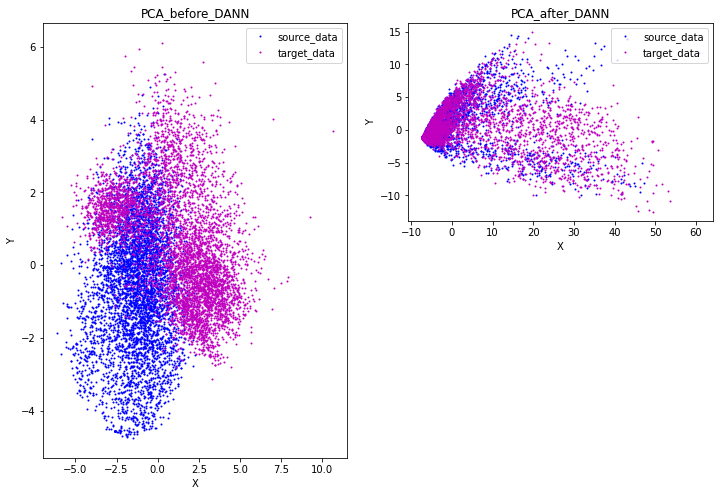

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(x_1_projected[:, 0], x_1_projected[:, 1], 'ro',color = 'b', markersize = 1, label = 'source_data')
plt.plot(y_1_projected[:, 0], y_1_projected[:, 1], 'ro',color = 'm', markersize = 1, label = 'target_data')
plt.title('PCA_before_DANN')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(x_2_projected[:, 0], x_2_projected[:, 1], 'ro',color = 'b', markersize = 1, label = 'source_data')
plt.plot(y_2_projected[:, 0], y_2_projected[:, 1], 'ro',color = 'm', markersize = 1, label = 'target_data')
plt.title('PCA_after_DANN')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.show()

# Q&A

有任何問題Domain Adaptation的問題可以寄信到b05902127@ntu.edu.tw / ntu-ml-2020spring-ta@googlegroups.com。

時間允許的話我會更新在這裡。

# Special Thanks
這次的作業其實是我出在2019FALL的ML Final Project，以下是我認為在Final Report不錯的幾組，有興趣的話歡迎大家參考看看。

[NTU_r08942071_太神啦 / 組長: 劉正仁同學](https://drive.google.com/open?id=11uNDcz7_eMS8dMQxvnWsbrdguu9k4c-c)

[NTU_r08921a08_CAT / 組長: 廖子毅同學](https://drive.google.com/open?id=1xIkSs8HAShdcfV1E0NEnf4JDbL7POZTf)
